In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(1337)

In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters:", len(text))
print(text[:500])

length of dataset in characters: 1115394
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [3]:
chars = sorted(set(text))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[ch] for ch in s]
def decode(l): return ''.join([itos[i] for i in l])
print(encode('hii there'))
print(decode(encode('hii there')))


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [4]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:50])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56])


In [5]:
batch_size = 64
block_size = 256
max_iters = 5000
eval_iters = 200
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
segmentation_ratio = 0.9
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
clip_grad_norm = 1.0

n = int(segmentation_ratio * len(data))
train_data = data[:n].to(device)
val_data = data[n:].to(device)

In [6]:
torch.manual_seed(1337)


def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i: i+block_size] for i in ix]).to(device)
    y = torch.stack([data[i+1: i+block_size+1] for i in ix]).to(device)
    return x, y

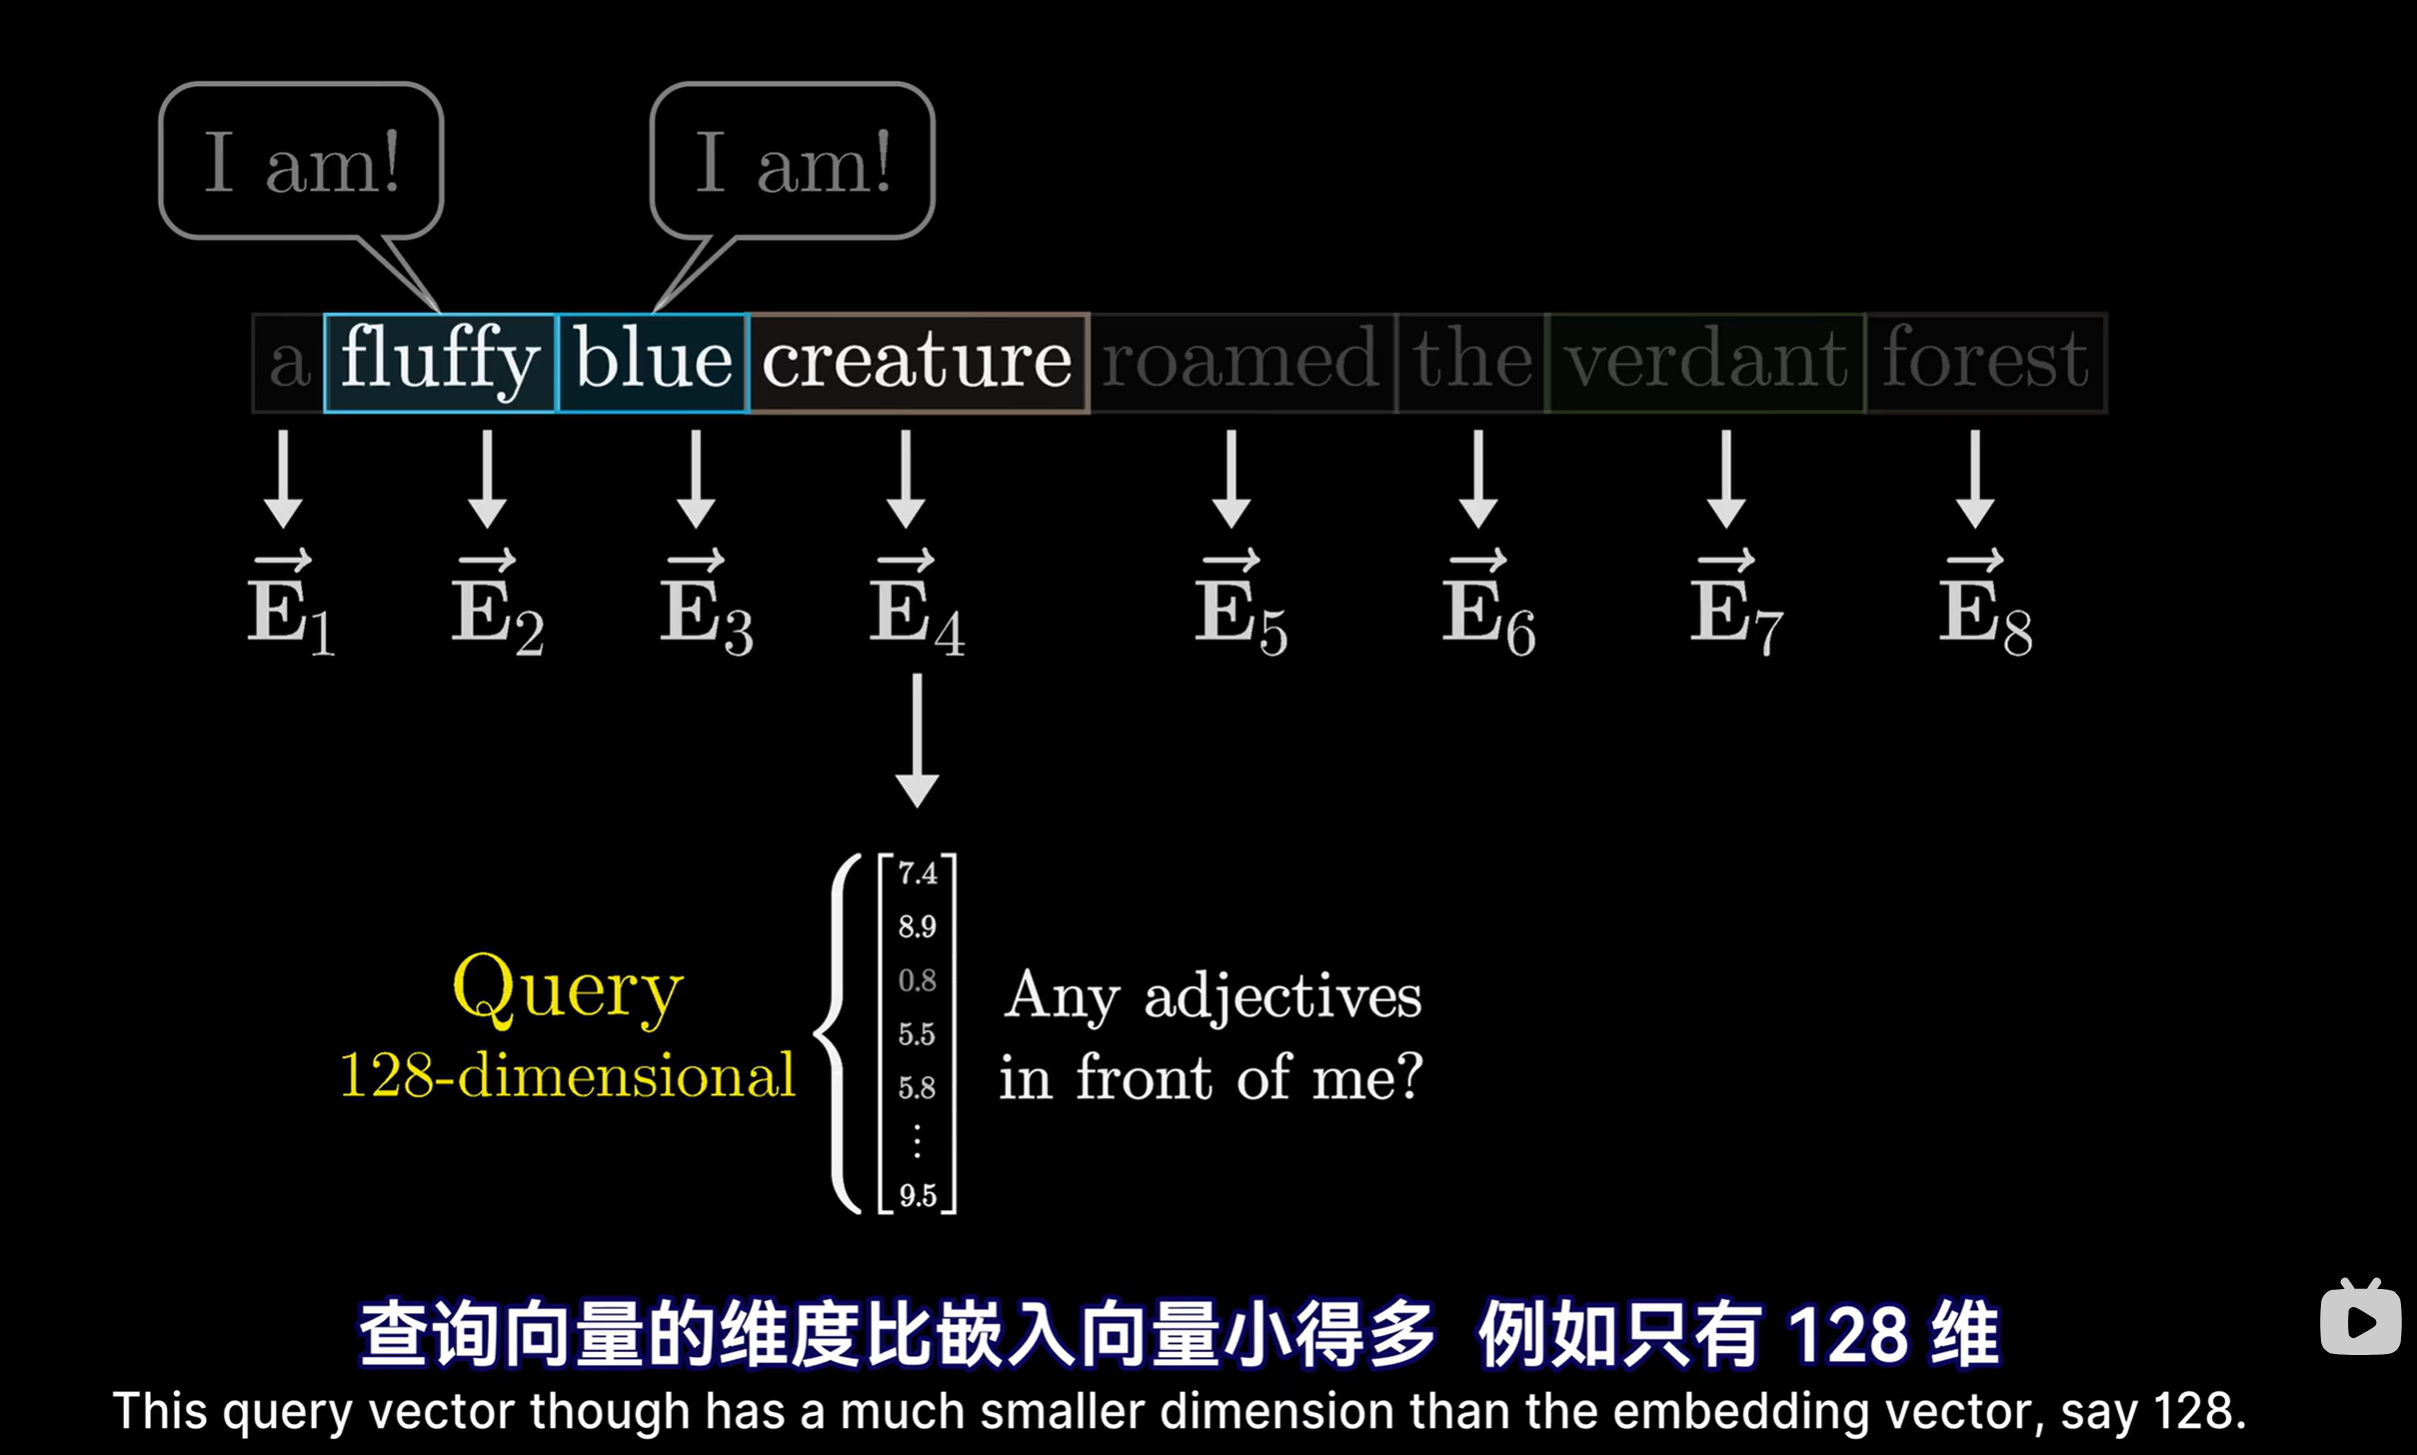

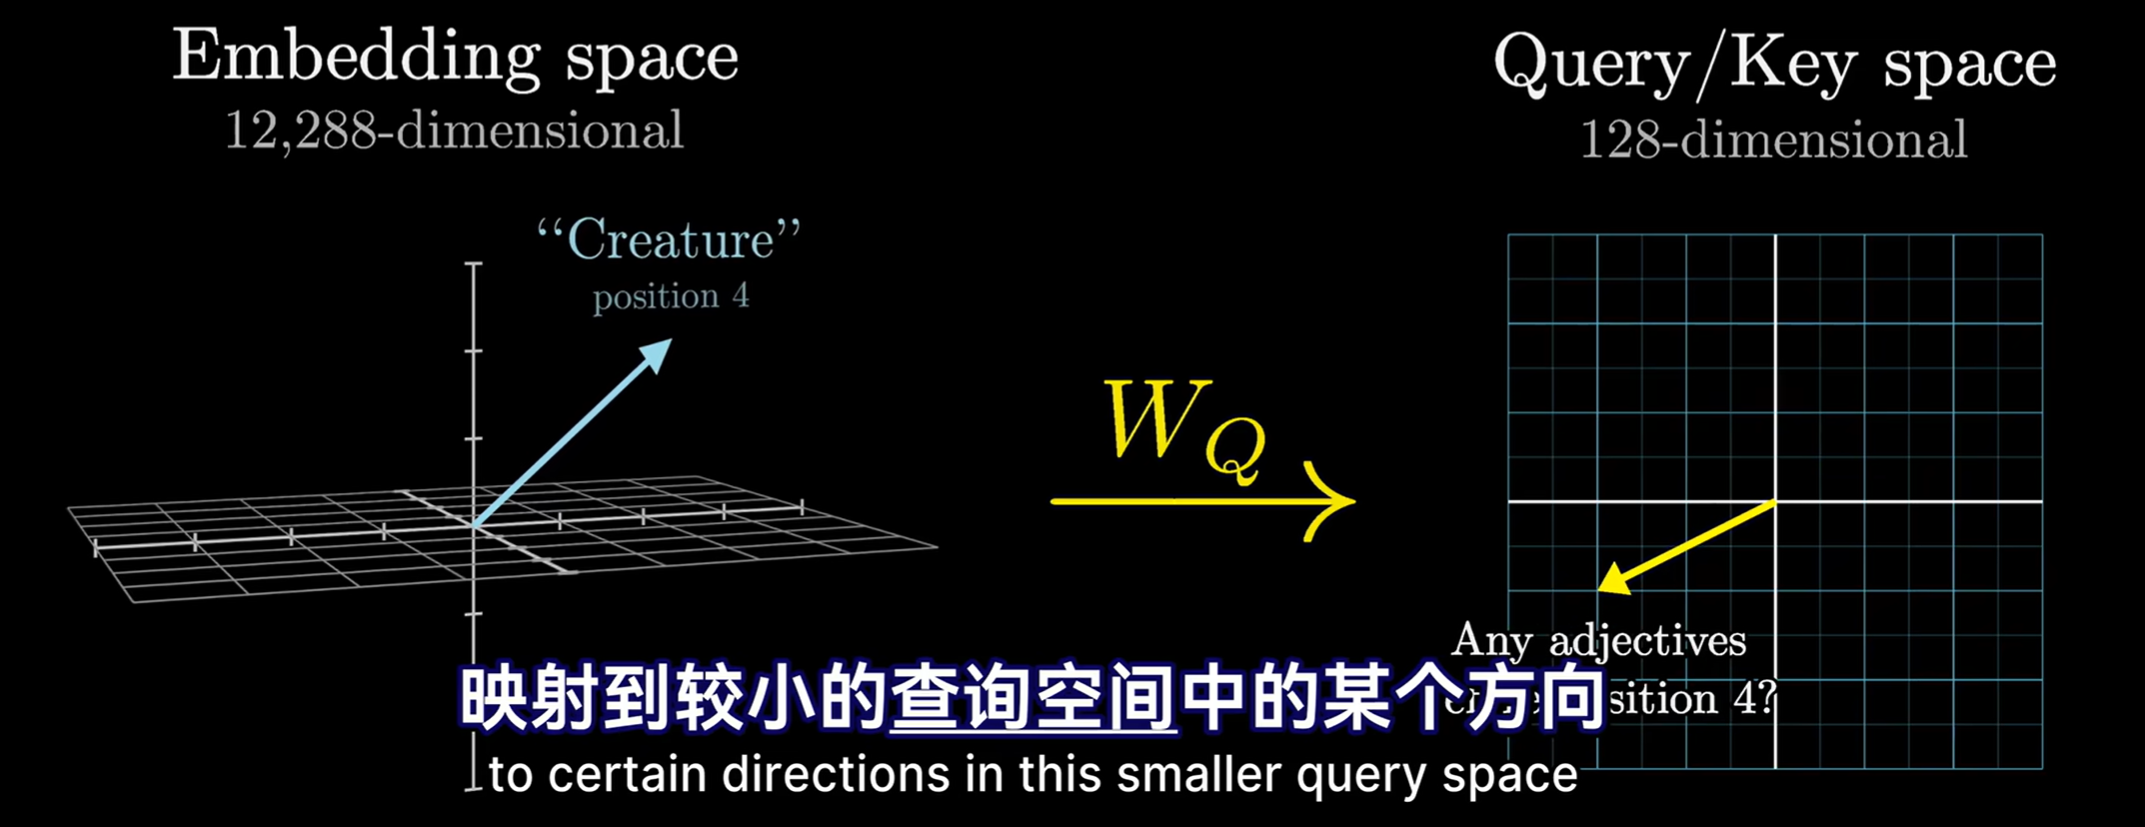

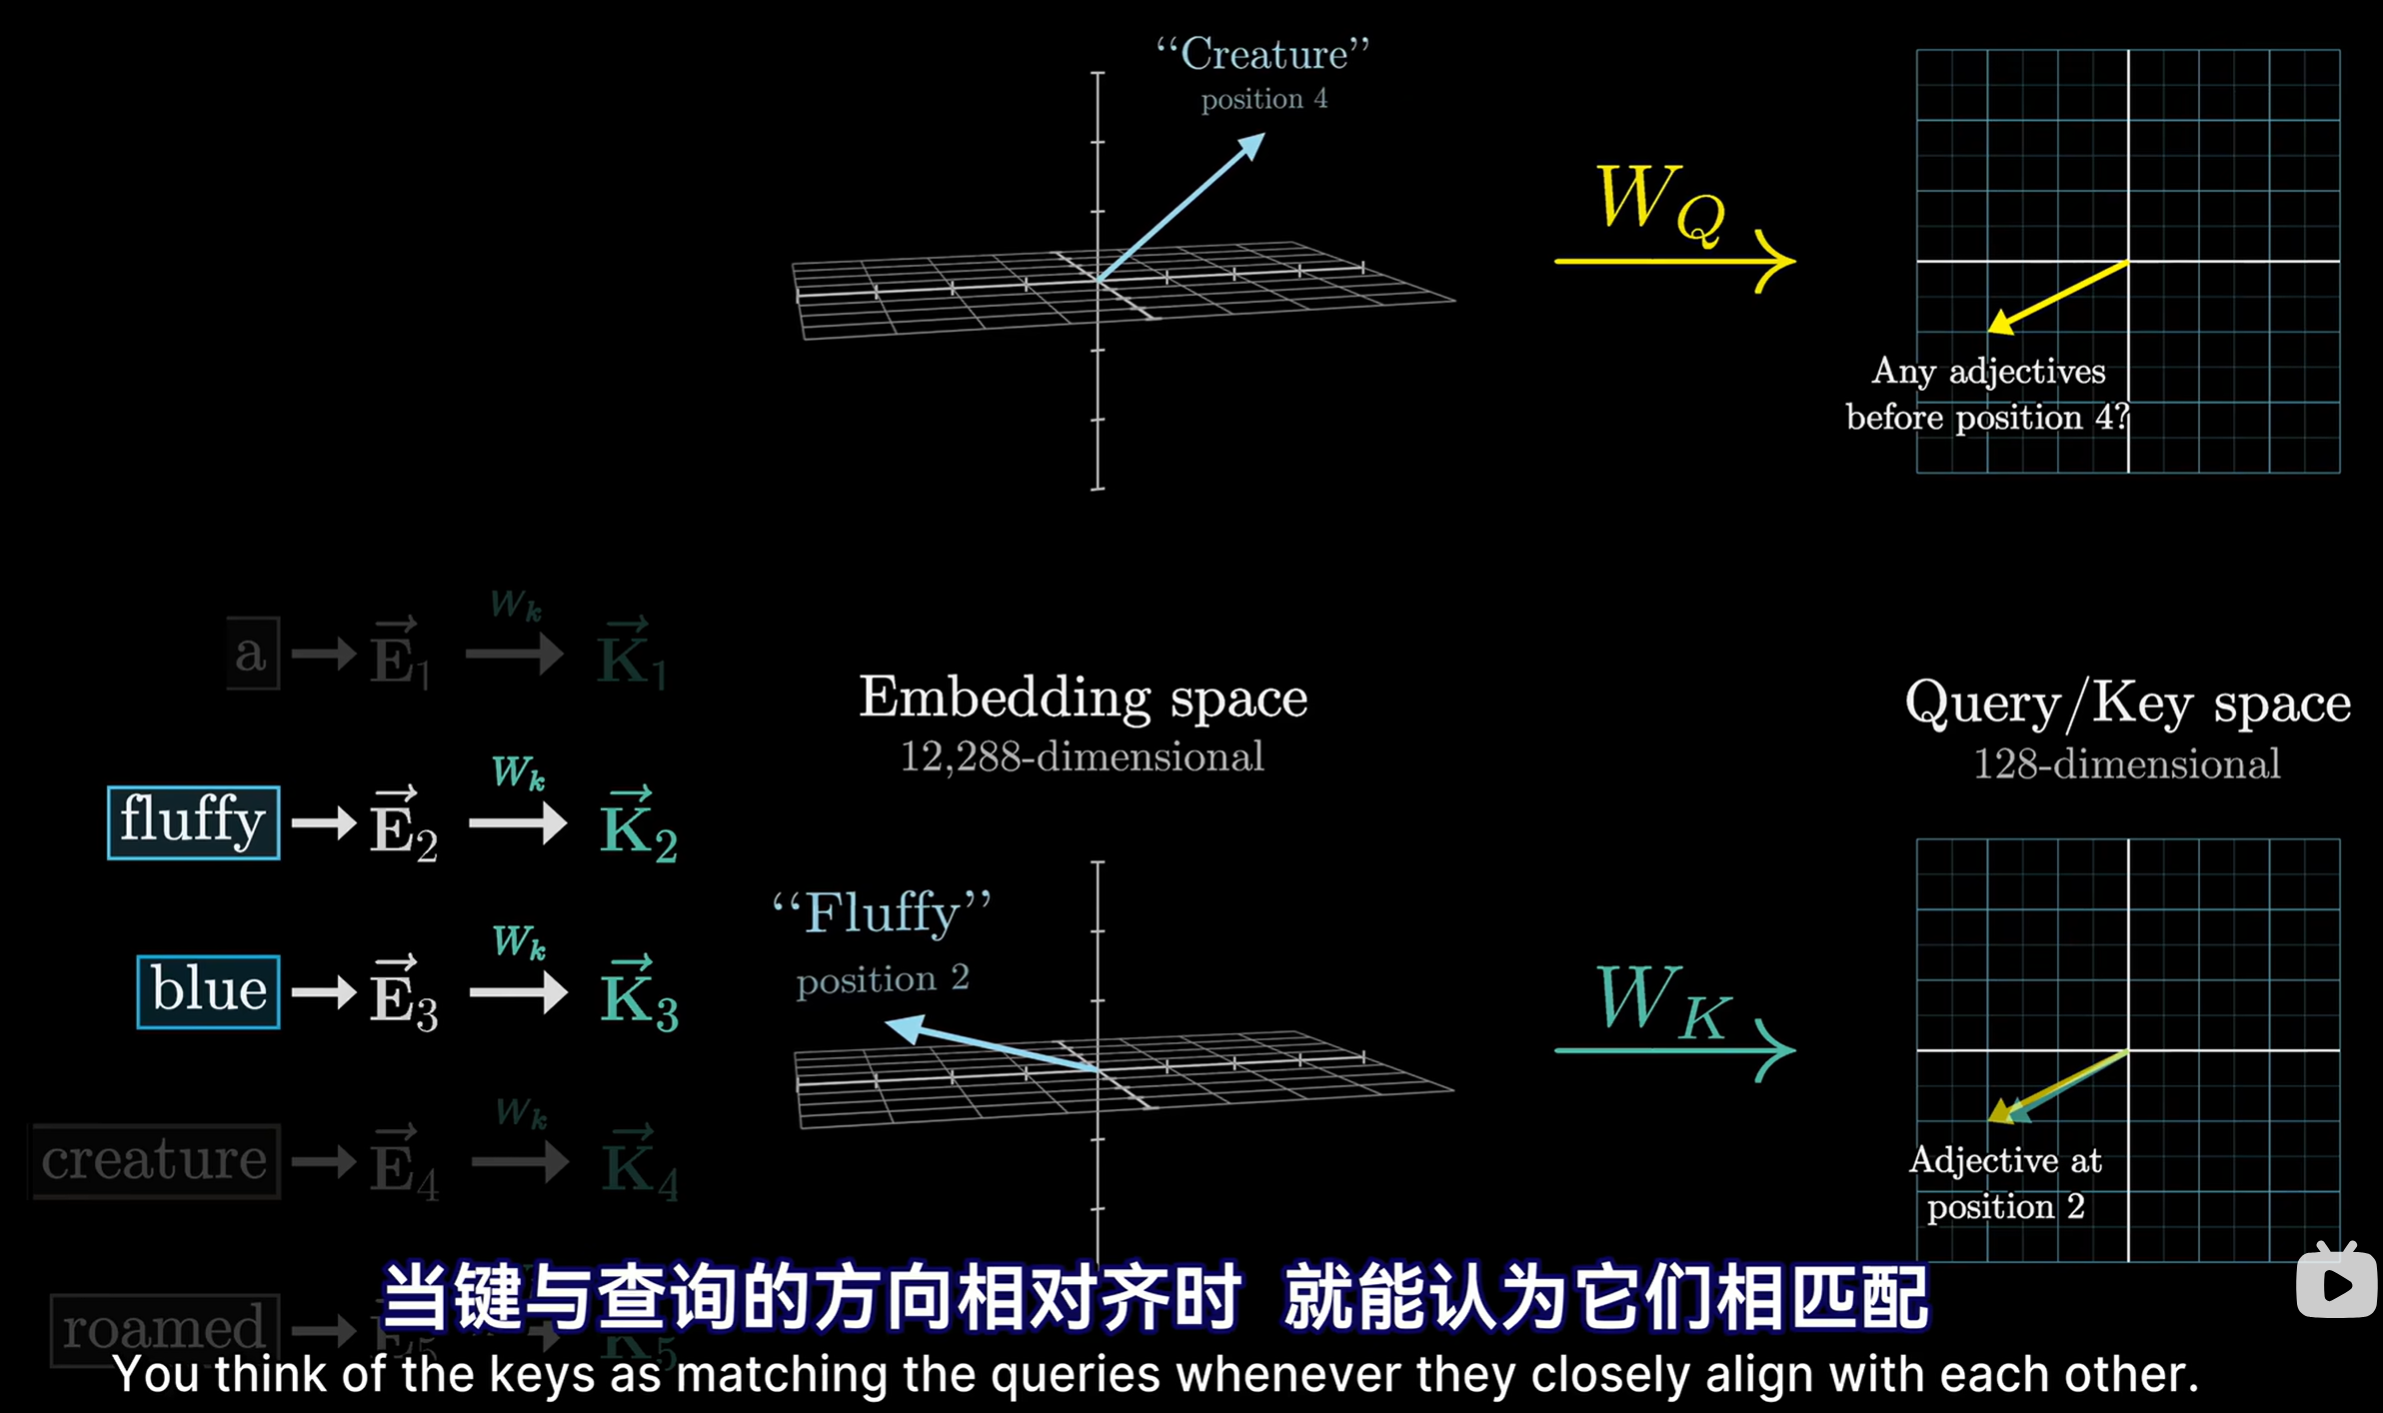

In [7]:
class CausalSelfAttention(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = head_size
        self.query = nn.Linear(n_embd, num_heads * head_size, bias=False)
        self.key = nn.Linear(n_embd, num_heads * head_size, bias=False)
        self.value = nn.Linear(n_embd, num_heads * head_size, bias=False)
        self.register_buffer('tril', torch.tril(
            torch.ones(block_size, block_size)))
        self.proj = nn.Linear(num_heads * head_size, n_embd)
        self.attn_dropout = nn.Dropout(dropout)
        self.resi_dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # TRAINING: (batch_size, block_size, n_embd)
        # INFERENCE: (1, 1->block_size, n_embd)
        # GENERAL: (B, T, n_embd)
        q = self.query(x).view(B, T, self.num_heads,
                               self.head_size).transpose(1, 2)
        k = self.key(x).view(B, T, self.num_heads,
                             self.head_size).transpose(1, 2)
        v = self.value(x).view(B, T, self.num_heads,
                               self.head_size).transpose(1, 2)
        # (B, num_heads, T, head_size)

        wei = q @ k.transpose(-2, -1) * self.head_size**-0.5
        # (B, num_heads, T, T)
        wei = wei.masked_fill(
            self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.attn_dropout(wei)
        # (B, num_heads, T, T)
        out = wei @ v
        # (B, num_heads, T, head_size)
        out = out.transpose(1, 2).contiguous().view(B, T, -1)
        # (B, T, num_heads * head_size)
        out = self.resi_dropout(self.proj(out))
        # (B, T, n_embd)
        return out

In [8]:
class FeedForward(nn.Module):

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(n_embd, 4 * n_embd),
                                 nn.ReLU(),
                                 nn.Linear(4 * n_embd, n_embd),
                                 nn.Dropout(dropout))

    def forward(self, x):
        return self.net(x)  # (B, T, n_embd)

In [9]:
class Block(nn.Module):

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = CausalSelfAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        # (B, T, n_embd) + (B, T, n_embd)
        x = x + self.ffwd(self.ln2(x))
        # (B, T, n_embd) + (B, T, n_embd)
        return x  # (B, T, n_embd)

In [10]:
class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        # TRAINING: (batch_size, block_size, n_embd)
        # INFERENCE: (1, 1->block_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # TRAINING: (block_size, n_embd)
        # INFERENCE: (1->block_size, n_embd)
        self.blocks = nn.Sequential(
            *[Block(n_embd, n_head) for _ in range(n_layer)])
        # (B, T, n_embd)
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)  # (B, T, vocab_size)

    def forward(self, indices, targets=None):
        # TRAINING: (batch_size, block_size)
        # INFERENCE: (1, 1->block_size)
        B, T = indices.shape
        tok_emb = self.token_embedding_table(indices)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        # TRAINING: (batch_size, block_size, n_embd)
        # INFERENCE: (1, 1->block_size, n_embd)
        # GENERAL: (B, T, C)
        x = self.blocks(x)  # (B, T, n_embd)
        x = self.ln_f(x)  # (B, T, n_embd)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx: (1, 1) -> (1, 500)
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]  # (1, 1->block_size)
            logits, loss = self(idx_cond)  # (1, 1->block_size, vocab_size)
            logits = logits[:, -1, :]  # (1, vocab_size)
            probs = F.softmax(logits, dim=1)  # (1, vocab_size)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


m = GPTLanguageModel().to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'Million parameters')

10.788929 Million parameters


In [11]:
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20)

In [12]:
@torch.no_grad()
def estimate_loss():
    out = {}
    m.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = m(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    m.train()
    return out

In [13]:
for iter in range(max_iters):

    if iter % eval_interval == 0:
        losses = estimate_loss()
        scheduler.step(losses['val'])
        print(
            f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = get_batch('train')

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(m.parameters(), clip_grad_norm)
    optimizer.step()

step 0: train loss 4.2858, val loss 4.2846
step 500: train loss 1.8499, val loss 1.9770
step 1000: train loss 1.5265, val loss 1.7209
step 1500: train loss 1.3870, val loss 1.6032
step 2000: train loss 1.3015, val loss 1.5453
step 2500: train loss 1.2446, val loss 1.5187
step 3000: train loss 1.1967, val loss 1.5006
step 3500: train loss 1.1551, val loss 1.4820
step 4000: train loss 1.1192, val loss 1.4792
step 4500: train loss 1.0821, val loss 1.4769


In [14]:
# single head:
# step 29700: train loss 2.3211, val loss 2.3519
# multi head(4):
# step 29700: train loss 2.1083, val loss 2.1756
# multi head(4) + feedforward:
# step 29700: train loss 2.0521, val loss 2.1578
# residual + 3 blocks:
# step 29700: train loss 1.8132, val loss 1.9439
# adding layer norm and dropout and scale up the model but only 5000 iters:
# step 4500: train loss 1.0879, val loss 1.4841
# merge the heads into the second dimension:
# step 4500: train loss 1.0821, val loss 1.4769

In [15]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))


Then, like and weet aged:
For early I am behind to somewhate-housed may had:
But as date to time letters what seels crown'd it.

Servant:
Set there, Marcius:
The sits what doth they straight trust heard it;
For drinkisted them and, this our treasure:
Where is it, so much, belove meet have the:
This calmest bread will I live.

Second Gentleman:
What, mark and that place my heirs?

CAPULET:
Shame, 'tis not worthy powers to they?
Though I speak, I recliment a man pre--wife,
Command straing death.
W


In [16]:
open('more.txt', 'w').write(
    decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

10001